<div align="center" style=" font-size: 80%; text-align: center; margin: 0 auto">
<img src="https://raw.githubusercontent.com/Explore-AI/Pictures/master/Python-Notebook-Banners/Examples.png"  style="display: block; margin-left: auto; margin-right: auto;";/>
</div>

# Examples: Build all the classifiers!
© ExploreAI Academy

In this notebook, we will explore building multiple types of classification models for the MBTI dataset and evaluate their performance using cross-validation.

## Learning Objectives

By the end of this notebook, you should be able to:

* Build multiple types of classification models.
* Evaluate the performance of each model using cross-validation.
* Determine which model performs best for the MBTI dataset.

## Introduction

In this train, we will throw some of the most common classifiers at the MBTI problem!  Let's not worry too much about what each algorithm is doing. Instead, we will focus on how to tell which model is likely to be better at solving this problem. To do so, we will fit the following classifiers to the MBTI dataset:

* Logistic regression
* K-nearest neighbours (KNN)
* Support vector machines (SVM)
* Decision trees
* [AdaBoost](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)

Then, we will leave it up to you to play with a few additional models:

* [Naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html)
* [LDA / QDA](https://scikit-learn.org/stable/modules/lda_qda.html)
* [Neural Network](https://scikit-learn.org/stable/modules/neural_networks_supervised.html)

This approach highlights a key principle in machine learning.  The best models are built through **iteration**. We need to be able to implement a 'quick and dirty' model that should give us a good idea of how to proceed in finding a better solution to a particular problem. The quicker we can generate a couple of results, the quicker we can come up with new ideas of how to proceed.

### Imports
To start, lets import everything we will require. This will be some feature extraction methods for text, methods to split our data, and all the models we want to train.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

### Data Pre-Processing

You should be familiar with these steps from previous trains on handling text data, specifically for the MBTI dataset.

**Note:** Depending on the machine you're using and the quality of the internet connection, the following cell may take several minutes to execute. 

In [4]:
## Read the data
print ('Reading the data into Pandas DF...')
mbti = pd.read_csv('https://raw.githubusercontent.com/Explore-AI/Public-Data/master/Data/classification_sprint/mbti_train.csv')

## Split the rows
# Separate each post in the 'posts' column into individual rows and create a new DataFrame
print ('Seperating data...')
all_mbti = []
for i, row in mbti.iterrows():
    for post in row['posts'].split('|||'):
        all_mbti.append([row['type'], post])
all_mbti = pd.DataFrame(all_mbti, columns=['type', 'post'])

## Remove urls
# Replace URLs in the 'post' column with a generic label
print ('Removing URLs...')
pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
subs_url = r'url-web'
all_mbti['post'] = all_mbti['post'].replace(to_replace = pattern_url, value = subs_url, regex = True)

# Make lower case
# Convert all text in the 'post' column to lowercase
print ('Lowering case...')
all_mbti['post'] = all_mbti['post'].str.lower()

# Remove punctuation
# Define a function to remove punctuation and numbers from the 'post' column
import string
print ('Cleaning punctuation...')
def remove_punctuation_numbers(post):
    punc_numbers = string.punctuation + '0123456789'
    return ''.join([l for l in post if l not in punc_numbers])
# Apply the remove_punctuation_numbers function to the 'post' column
all_mbti['post'] = all_mbti['post'].apply(remove_punctuation_numbers)

Reading the data into Pandas DF...
Seperating data...
Removing URLs...
Lowering case...
Cleaning punctuation...


For this example, we will only be looking at the Introvert / Extrovert dimension.

In [12]:
# Extract the first letter of the 'type' column to determine if the person is introverted (I) or not
all_mbti['I'] = all_mbti['type'].apply(lambda x: x[0] == 'I').astype('int')
# Assign the target variable to 'y'
y = all_mbti['I']
y.shape

(316548,)

Now, let's fit the data to the Count Vectorizer, removing all English stop words.

In [14]:
vect = CountVectorizer(stop_words='english', min_df= .01)
X = vect.fit_transform(all_mbti['post'])

We have a lot of training data here!  To speed up the algorithms and illustrate the effects, we will only be using the first 5,000 rows of data.  Play around with the size of the data to get a feel of how each algorithm responds to more data from an accuracy and training time point of view.

In [15]:
n = 5000
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X[:n].toarray(), y[:n])

## Let's build some classification models!

In the next two cells, we will define the model names and call the model implementation classes. Note how some of the classifiers need input variables.  These are examples of **hyperparameters**. 

In [18]:
# Define the names of the classifiers
names = ['Logistic Regression', 'Nearest Neighbors', 
         'Linear SVM', 'RBF SVM',          
         'Decision Tree', 'Random Forest',  'AdaBoost']

In [20]:
# Define the classifiers with their respective hyperparameters
classifiers = [
    LogisticRegression(), 
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),    
    AdaBoostClassifier()
]

While this next cell is running, see if you can tell which algorithm takes the longest to train. Why do you think this is so?

In [22]:
# Empty lists to store results
results = []  # Store evaluation metrics for each classifier
models = {}  # Store trained models
confusion = {}  # Store confusion matrices for each classifier
class_report = {}  # Store classification reports for each classifier

# Iterate over each classifier
for name, clf in zip(names, classifiers):    
    print ('Fitting {:s} model...'.format(name))
    # Measure the time taken to fit the model
    run_time = %timeit -q -o clf.fit(X_train, y_train)
    
    print ('... predicting')
    # Predict on the training data
    y_pred = clf.predict(X_train)   
    y_pred_test = clf.predict(X_test)
    
    print ('... scoring')
    # Calculate evaluation metrics
    accuracy  = metrics.accuracy_score(y_train, y_pred)
    precision = metrics.precision_score(y_train, y_pred)
    recall    = metrics.recall_score(y_train, y_pred)
    
    f1        = metrics.f1_score(y_train, y_pred)    
    f1_test   = metrics.f1_score(y_test, y_pred_test)    
    
    # Save the results to dictionaries
    models[name] = clf    
    confusion[name] = metrics.confusion_matrix(y_train, y_pred)
    class_report[name] = metrics.classification_report(y_train, y_pred)
    
    # Append results to the list
    results.append([name, accuracy, precision, recall, f1, f1_test, run_time.best])

    
# Convert results to DataFrame for easy visualisation
results = pd.DataFrame(results, columns=['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1 Train', 'F1 Test', 'Train Time'])
results.set_index('Classifier', inplace= True)

print ('... All done!')

Fitting Logistic Regression model...
... predicting
... scoring
Fitting Nearest Neighbors model...
... predicting
... scoring
Fitting Linear SVM model...
... predicting
... scoring


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fitting RBF SVM model...
... predicting
... scoring
Fitting Decision Tree model...
... predicting
... scoring
Fitting Random Forest model...
... predicting
... scoring
Fitting AdaBoost model...


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packag

... predicting
... scoring
... All done!


Now let's take a look at the results.

In [24]:
results.sort_values('F1 Train', ascending=False)

,Accuracy,Precision,Recall,F1 Train,F1 Test,Train Time
Classifier,,,,,,
RBF SVM,0.957333,0.950747,0.998332,0.973958,0.888391,0.521301
Nearest Neighbors,0.836000,0.854043,0.958625,0.903317,0.848600,0.000282
Decision Tree,0.805867,0.807703,0.993660,0.891083,0.888093,0.010148
AdaBoost,0.802667,0.804588,0.994661,0.889585,0.888592,0.280626
Logistic Regression,0.800533,0.802204,0.995996,0.888657,0.888592,0.007403
Linear SVM,0.799200,0.799200,1.000000,0.888395,0.890368,0.209503
Random Forest,0.799200,0.799200,1.000000,0.888395,0.890368,0.012167


This is way too many numbers to comprehend. Let's plot these values to see if we can make sense of them.

Text(0.5, 1.0, 'Training Time vs. Classifier')

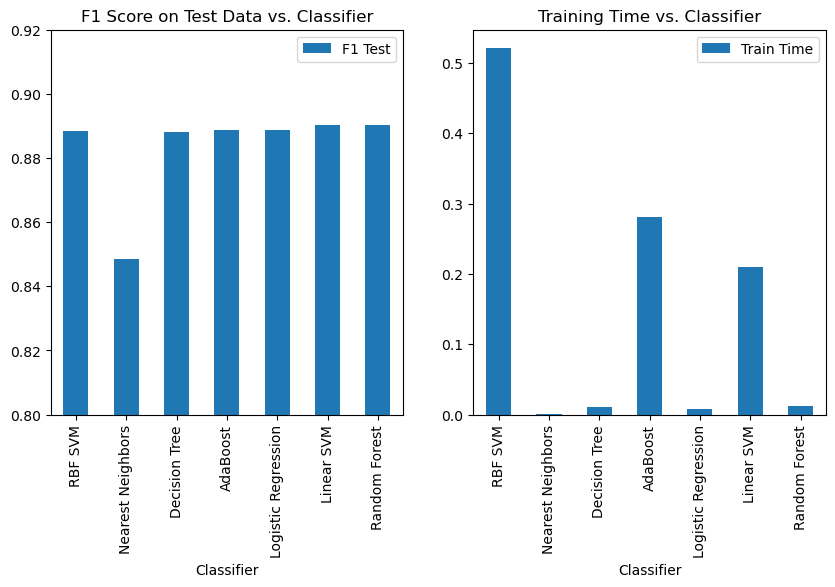

In [26]:
# Plot F1 Score on Test Data vs. Classifier
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
results.sort_values('F1 Train', ascending=False, inplace=True)
results.plot(y=['F1 Test'], kind='bar', ax=ax[0], xlim=[0,1.1], ylim=[0.80,0.92])
ax[0].set_title('F1 Score on Test Data vs. Classifier')
results.plot(y='Train Time', kind='bar', ax=ax[1])
ax[1].set_title('Training Time vs. Classifier')

To better understand the performance of the models, let's view the confusion matrices and classification reports of their results.

In [28]:
# Display confusion matrices and classification reports
for name, matrix in confusion.items():
    print(f"Confusion Matrix for {name}:")
    print(matrix)
    print()
    
for name, report in class_report.items():
    print(f"Classification Report for {name}:")
    print(report)
    print()

Confusion Matrix for Logistic Regression:
[[  17  736]
 [  12 2985]]

Confusion Matrix for Nearest Neighbors:
[[ 262  491]
 [ 124 2873]]

Confusion Matrix for Linear SVM:
[[   0  753]
 [   0 2997]]

Confusion Matrix for RBF SVM:
[[ 598  155]
 [   5 2992]]

Confusion Matrix for Decision Tree:
[[  44  709]
 [  19 2978]]

Confusion Matrix for Random Forest:
[[   0  753]
 [   0 2997]]

Confusion Matrix for AdaBoost:
[[  29  724]
 [  16 2981]]

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.59      0.02      0.04       753
           1       0.80      1.00      0.89      2997

    accuracy                           0.80      3750
   macro avg       0.69      0.51      0.47      3750
weighted avg       0.76      0.80      0.72      3750


Classification Report for Nearest Neighbors:
              precision    recall  f1-score   support

           0       0.68      0.35      0.46       753
           1       0.85    

Can you use the above metrics to analyse the performance of the models? Which model do you think outperforms the rest?

## Model Validation

But how do we know if these models are robust?  

Model validation is the process of checking if our model produces reliable results. In order to make an informed choice, we need a way to *validate* that our model and our hyperparameters are a good fit to the data.

### K-Fold Cross Validation

In the rest of this train, we consider a common approach to validation called `k-fold cross validation`.

`K-fold cross-validation` is a technique used to evaluate the performance of machine learning models. It involves partitioning the dataset into k equal-sized folds, where each fold is used as a validation set while the remaining k-1 folds are used for training the model. This process is repeated k times, with each fold used exactly once as the validation data. 

The advantage of k-fold cross-validation is that it provides a **more reliable estimate of model performance** compared to a single train-test split. It helps to reduce the variance of the evaluation metrics, especially when the dataset is small or when the train-test split may not be representative of the entire dataset.

In each iteration of k-fold cross-validation, the model is trained on `k-1 folds` and evaluated on the remaining fold. This process allows for a more comprehensive assessment of the model's performance across different subsets of the data.

After performing k-fold cross-validation, the `performance metrics` (e.g., accuracy, precision, recall) obtained from each fold are averaged to obtain a single estimate of the model's performance. Additionally, the standard deviation of the metrics can provide insights into the variability of the model's performance across different folds.

Overall, k-fold cross-validation is a valuable technique for assessing the generalisation ability of machine learning models and can help in selecting the best model and hyperparameters for a given dataset.

Cross-validation can be easily implemented using `sklearn`. Let's do that for our Logistic Regression model and print out the performance of each fold.

In [30]:
# Retrieve the trained Logistic Regression model from the 'models' dictionary
model = models['Logistic Regression']

# Perform k-fold cross-validation on the Logistic Regression model
# using the entire dataset (first n samples) and the target variable y
# Print the cross-validation scores
print(cross_val_score(model, X[:n].toarray(), y[:n]))

[0.799 0.794 0.788 0.798 0.799]


Let's now do the same for each of our models and print out the mean and standard deviation of each model's cross validation.

In [36]:
# Initialize an empty list to store cross-validation results
cv = []

# Iterate over each model in the 'models' dictionary
for name, model in models.items():
    print()  # Print an empty line for better readability
    print(name)  # Print the name of the current model
    # Perform k-fold cross-validation (with k=10) on the current model
    scores = cross_val_score(model, X=X[:n].toarray(), y=y[:n], cv=10)
    # Calculate the mean and standard deviation of the cross-validation scores
    print(f"Accuracy: {scores.mean():0.2f} (+/- {scores.std():0.4f})")
    # Append the model name, mean cross-validation score, and standard deviation to the 'cv' list
    cv.append([name, scores.mean(), scores.std()])

# Convert the list of cross-validation results to a DataFrame
cv = pd.DataFrame(cv, columns=['Model', 'CV_Mean', 'CV_Std_Dev'])

# Set the index of the DataFrame to the model names
cv.set_index('Model', inplace=True)


Logistic Regression
Accuracy: 0.80 (+/- 0.0051)

Nearest Neighbors
Accuracy: 0.70 (+/- 0.0231)

Linear SVM
Accuracy: 0.80 (+/- 0.0000)

RBF SVM



KeyboardInterrupt



Now we can compare these results using a bar chart. Which model do you think is best suited to our dataset?

<Axes: xlabel='Model'>

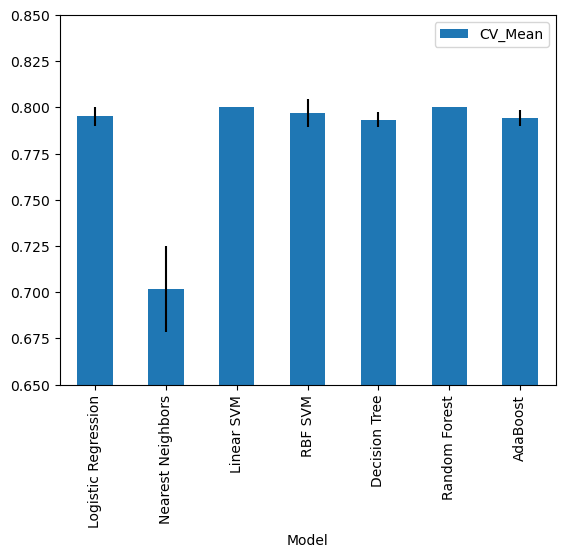

In [34]:
# Plot the mean cross-validation scores with error bars representing the standard deviation
# Set the y-axis to represent the mean cross-validation scores
# Set the error bars to represent the standard deviation of the cross-validation scores
# Limit the y-axis to the range [0.65, 0.85] for better visualization
cv.plot(y='CV_Mean', yerr='CV_Std_Dev', kind='bar', ylim=[0.65, 0.85])


From the graph above, we can see that logistic regression, the SVM variants, and the Random Forest model all perform similarly and post good metric scores. On the other hand, our KNN classifier performed by far the worst. This can be expected seeing that we arbitrarily chose the value of `k` as 3 for that model.  

This last point brings us back full circle to the introduction, where we spoke about **iteration**. Having performed our initial analysis, we can now ask several additional questions about our modelling problem:

 - Should we continue to investigate the performance of the KNN model under different settings of `k`? 
 - Seeing that most of the scores are very similar, should we try to use additional metrics to better differentiate model performance? Perhaps we just need to add some more of our original data?  
 - Is performance the only aspect we care about for our given task? Should we focus on other model characteristics such as execution time, or memory consumption?   
 - Are the current scores good enough? If not, should we investigate more models or instead focus on improving the current ones through techniques such as hyperparameter tuning? 
 
As we can see, there are numerous questions to consider, and this list is by no means exhaustive. Developing proficiency as a data scientist involves discerning which questions are most relevant to the specific task at hand. This skill requires practice and the utilisation of your analytical abilities.


## Conclusion

That is a lot of classifiers! In this train we built seven different classification models and trained these on the MBTI dataset. To ensure that we got a robust measure of classifier performance, we then applied cross-validation to these models. Performing this analysis allowed us to reflect on our problem at hand; generating further questions to lead us along the iterative process of improving our model-based solution.  

While we've explored several classification models, there are still additional models left for further experimentation. We encourage you to explore the performance of models such as `Naive Bayes`, `LDA / QDA`, and `Neural Networks` on the dataset. These models offer different approaches and complexities that may yield valuable insights or improved performance.

#  

<div align="center" style=" font-size: 80%; text-align: center; margin: 0 auto">
<img src="https://raw.githubusercontent.com/Explore-AI/Pictures/master/ExploreAI_logos/EAI_Blue_Dark.png"  style="width:200px";/>
</div>